In [1]:
import json
import os
from pathlib import Path
import sys
import time

from IPython.display import display
import joblib
import matplotlib
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.ensemble
import sklearn.feature_selection
import sklearn.metrics
import sklearn.model_selection
from tqdm.auto import tqdm

from run import filepath_x, filepath_y, filepath_s, filepath_performance_folds, filepath_outer_folds

X = pd.read_pickle(filepath_x)
y = pd.read_pickle(filepath_y)
s = pd.read_pickle(filepath_s)
outer_folds = joblib.load(filepath_outer_folds)


# Feature properties

In [3]:
number_of_journeys = X[('number_of_journeys', 0)] - 1
norm = int(number_of_journeys.sum())

message = "Total journeys where one port is missing"
value = int((X[('one_node_missing', 0)]*number_of_journeys).sum())
print(f"{message}: {value} ({value/norm:.2%})")

message = "Total journeys where both ports are missing"
value = int((X[('both_nodes_missing', 0)]*number_of_journeys).sum())
print(f"{message}: {value} ({value/norm:.2%})")

Total journeys where one port is missing: 53728 (1.95%)
Total journeys where both ports are missing: 63447 (2.31%)


# Determine best parameters 
Determine for every value of orthogonality and for every outer fold

In [10]:
best_params = (
    pd.read_pickle(filepath_performance_folds)
    .groupby(['orthogonality', 'outer_fold', 'max_depth', 'n_bins'], as_index=False)
    .agg({'auc_y': 'mean', 'auc_s': 'mean'})
    .sort_values('auc_y', ascending=False)
    .drop_duplicates(subset=['orthogonality', 'outer_fold'])
    .sort_values(['orthogonality', 'outer_fold'])
    [['orthogonality', 'outer_fold', 'max_depth', 'n_bins']]
)

# Measure total performance

In [11]:
total_performance_before_aggregation = list()
for p in tqdm(list(best_params.itertuples())):
    y_score = np.load(f'models/outer_folds/{p.max_depth}-{p.orthogonality:.2f}-{p.n_bins}-{p.outer_fold}.npy')
    
    _, (_, test_idx) = outer_folds[p.outer_fold]
    y_test = y[test_idx]
    s_test = s[test_idx]
    auc_y = sklearn.metrics.roc_auc_score(y_test, y_score)
    auc_s = sklearn.metrics.roc_auc_score(s_test, y_score)
    auc_s = max(auc_s, 1-auc_s)    
    
    total_performance_before_aggregation.append(
        dict(orthogonality=p.orthogonality, auc_y=auc_y, auc_s=auc_s, 
             fold=p.outer_fold)
    )
total_performance_before_aggregation = pd.DataFrame(total_performance_before_aggregation)
total_performance = (
    total_performance_before_aggregation
    .groupby(['orthogonality'])
    .agg(auc_y=('auc_y', 'mean'), auc_y_std=('auc_y', 'std'),
         auc_s=('auc_s', 'mean'), auc_s_std=('auc_s', 'std'))
)

  0%|          | 0/55 [00:00<?, ?it/s]

In [12]:
total_performance

,auc_y,auc_y_std,auc_s,auc_s_std
orthogonality,,,,
0.0,0.814402,0.003850,0.626898,0.013815
0.1,0.813765,0.003883,0.617525,0.012643
0.2,0.812861,0.005782,0.607162,0.013119
0.3,0.807987,0.003998,0.597155,0.012933
0.4,0.803892,0.006532,0.582603,0.013076
0.5,0.801250,0.004161,0.569496,0.010762
0.6,0.788647,0.007466,0.552828,0.014602
0.7,0.776182,0.008163,0.537640,0.010588
0.8,0.766792,0.008514,0.529537,0.011115


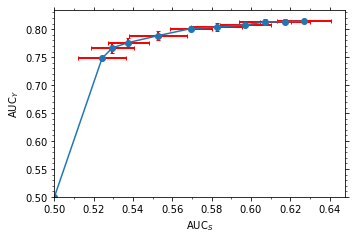

In [13]:
fig, ax = plt.subplots(figsize=(4.82,4.82*(2/3)), constrained_layout=True)
ax.errorbar(data=total_performance,x='auc_s', y='auc_y', xerr='auc_s_std', yerr='auc_y_std', ecolor='red', elinewidth=2, capsize=2, marker='o')
ax.xaxis.set_minor_locator(MultipleLocator(.01))
ax.yaxis.set_minor_locator(MultipleLocator(.01))
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.set_xlim(.5)
ax.set_ylim(.5)
ax.set_xlabel(r'$\mathrm{AUC}_S$')
ax.set_ylabel(r'$\mathrm{AUC}_Y$');
fig.savefig('fig/auc-plot.pdf')

# Determine $\Theta^\ast$

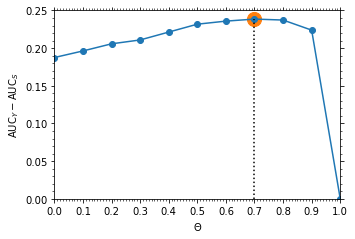

In [14]:
fig, ax = plt.subplots(figsize=(4.82,4.82*(2/3)), constrained_layout=True)
objective = total_performance.auc_y-total_performance.auc_s
ortho_star = (total_performance.auc_y-total_performance.auc_s).idxmax()
objective_star = objective.max()
objective.plot(marker='o', ax=ax)
ax.scatter(ortho_star, objective_star, marker='o', c='C1', s=200)
ax.vlines(ortho_star, 0, objective_star, color='black', ls=':')
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_minor_locator(MultipleLocator(.01))
ax.xaxis.set_major_locator(MultipleLocator(.1))
ax.yaxis.set_minor_locator(MultipleLocator(.01))
ax.set_xlim(0, 1)
ax.set_ylim(0)
ax.set_xlabel(r'$\Theta$')
ax.set_ylabel(r'$\mathrm{AUC}_Y - \mathrm{AUC}_S$')
fig.savefig('fig/objective.pdf')

# Determine $\hat y$ and threshold

In [15]:
iterator = list(best_params.loc[lambda x: x.orthogonality == ortho_star].itertuples())

y_scores_all = list()
y_test_all = list()
s_test_all = list()
for p in tqdm(iterator): 
    y_score = np.load(f'models/outer_folds/{p.max_depth}-{p.orthogonality:.2f}-{p.n_bins}-{p.outer_fold}.npy')
    
    _, (_, test_idx) = outer_folds[p.outer_fold]
    
    y_test = y[test_idx]
    s_test = s[test_idx]
    
    # FLIPPING!!!
    y_scores_all.extend(1-y_score)
    y_test_all.extend(~y_test)
    
    s_test_all.extend(s_test)
    
y_scores_all = np.array(y_scores_all)
y_test_all = np.array(y_test_all)
s_test_all = np.array(s_test_all)

threshold = np.quantile(y_scores_all, np.mean(~y_test_all))
y_pred_all = y_scores_all > threshold

  0%|          | 0/5 [00:00<?, ?it/s]

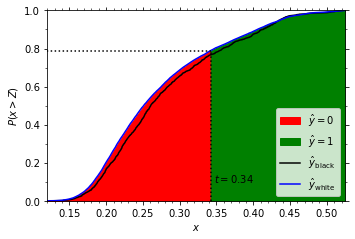

In [16]:
fig, ax = plt.subplots(figsize=(4.82,4.82*(2/3)), constrained_layout=True)
y_scores_sorted = np.sort(y_scores_all)
y1 = 1. * np.arange(len(y_scores_sorted)) / (len(y_scores_sorted) - 1)
y_scores_sorted_b = np.sort(y_scores_all[s_test_all])
y2 = 1. * np.arange(len(y_scores_sorted_b)) / (len(y_scores_sorted_b) - 1)
y_scores_sorted_w = np.sort(y_scores_all[~s_test_all])
y3 = 1. * np.arange(len(y_scores_sorted_w)) / (len(y_scores_sorted_w) - 1)

threshold_idx = np.argmax(np.sort(y_scores_all) > threshold)
ax.text(threshold+.005, .1, rf"$t={threshold:.02}$")
ax.fill_between(y_scores_sorted[:threshold_idx], y1[:threshold_idx], color='red', label=r'$\^y = 0$')
ax.fill_between(y_scores_sorted[threshold_idx:], y1[threshold_idx:], color='green', label=r'$\^y = 1$')
ax.plot(y_scores_sorted_b, y2, color='black', label=r'$\^y_\mathrm{black}$')
ax.plot(y_scores_sorted_w, y3, color='blue', label=r'$\^y_\mathrm{white}$')

ax.vlines(threshold, 0, y1[threshold_idx], color='black', ls=':')
ax.hlines(y1[threshold_idx], 0, threshold, color='black', ls=':')
ax.legend(loc='lower right')
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_minor_locator(MultipleLocator(.01))
ax.yaxis.set_minor_locator(MultipleLocator(.1))
ax.set_xlim(y_scores_sorted[0], y_scores_sorted[-1])
ax.set_ylim(0, 1)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$P(x > Z)$')
fig.savefig('fig/score-cdf.pdf')

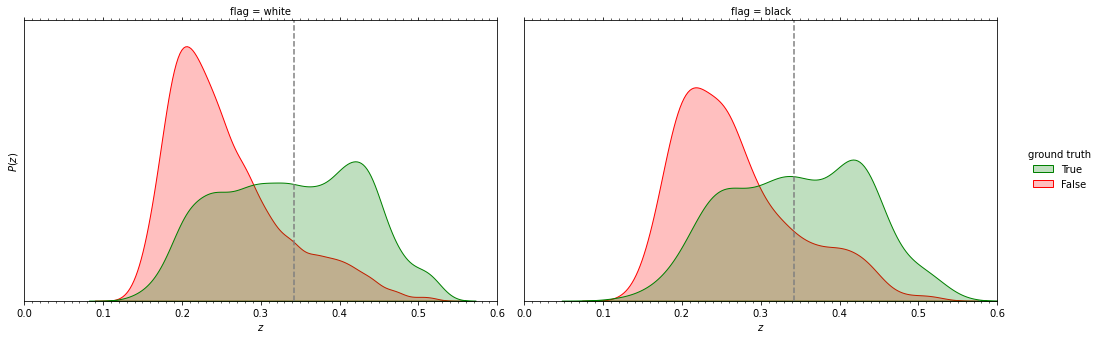

In [17]:
data_ = pd.DataFrame({'x': y_scores_all, 'ground truth': y_test_all, 'flag': np.where(s_test_all, 'black', 'white')})
g = sns.displot(
    data=data_, x='x', hue='ground truth', col='flag', kind='kde', hue_order=[True, False], palette=['green', 'red'], common_norm=False, fill=True, height=4.82, aspect=3/2, 
    facet_kws={'despine': False, 'xlim': (0, .6)}
)
# sns.despine(top=False, right=False)
g.refline(x=threshold)
g.set_axis_labels(r'$z$', r'$P(z)$')
g.set_yticklabels([])
g.set(yticks=[])
g.axes[0][0].xaxis.set_minor_locator(MultipleLocator(.01))
g.axes[0][0].xaxis.set_ticks_position('both')
g.axes[0][1].xaxis.set_ticks_position('both')
plt.savefig('fig/score-pdf.pdf')

In [18]:
objs = [
    pd.crosstab(
        pd.Series(y_test_all[s_test_all ], name='Inspection outcome').replace({True: 'Compliant', False: 'Non-compliant'}), 
        pd.Series(y_pred_all[s_test_all ], name='Predicted'         ).replace({True: 'Compliant', False: 'Non-compliant'})
    ),
    pd.crosstab(
        pd.Series(y_test_all[~s_test_all], name='Inspection outcome').replace({True: 'Compliant', False: 'Non-compliant'}), 
        pd.Series(y_pred_all[~s_test_all], name='Predicted'         ).replace({True: 'Compliant', False: 'Non-compliant'})
    )
]
pd.concat(objs, axis=1, keys=['black', 'white'], names=['flag'])

flag                   black                   white              
Predicted          Compliant Non-compliant Compliant Non-compliant
Inspection outcome                                                
Compliant                143           136      2519          2623
Non-compliant            233          1101      2526         16293

# Determine fairness measures with prior threshold

In [19]:
values = [np.around(ortho, 1) for ortho in np.linspace(0, 1, 11)]
iterator = [(ortho, fold) for ortho in values for fold in range(5)]

y_scores_all = {np.around(orthogonality, 1): [] for orthogonality in values}
y_test_all = {np.around(orthogonality, 1): [] for orthogonality in values}
s_test_all = {np.around(orthogonality, 1): [] for orthogonality in values}
y_pred_all = {np.around(orthogonality, 1): [] for orthogonality in values}
fairness_measures = list()

for ortho, fold in tqdm(iterator):  
    best_params_ = best_params.loc[lambda x: (x.orthogonality.round(1) == ortho) & (x.outer_fold == fold)].iloc[0]
    max_depth = int(best_params_['max_depth'])
    n_bins = int(best_params_['n_bins'])
    filepath = f'models/outer_folds/{max_depth}-{ortho:.2f}-{n_bins}-{fold}.npy'
    y_score = np.load(filepath)
    
    _, (_, test_idx) = outer_folds[fold]
    assert len(y_score) == len(test_idx)
    
    y_test = y[test_idx]
    s_test = s[test_idx]
    
    # FLIPPING!!!
    y_scores_all[ortho].extend(1-y_score)
    y_test_all[ortho].extend(~y_test)
    s_test_all[ortho].extend(s_test)

for ortho in values:
    y_score = np.array(y_scores_all[ortho])
    y_test = np.array(y_test_all[ortho])
    s_test = np.array(s_test_all[ortho])
    threshold = np.quantile(y_scores_all[ortho], np.mean(~y_test))

    y_pred = y_score > threshold
    ppr_w = y_pred[~s_test].mean()
    ppr_b = y_pred[s_test].mean()

    fpr_w = (y_score > threshold)[~y_test & ~s_test].mean()
    fpr_b = (y_score > threshold)[~y_test & s_test].mean()
    tpr_w = (y_score > threshold)[y_test & ~s_test].mean()
    tpr_b = (y_score > threshold)[y_test & s_test].mean()

    fairness_measures.append(
        {
            'precision (white)': sklearn.metrics.precision_score(y_test[~s_test], y_pred[~s_test]),
            'precision (non-white)': sklearn.metrics.precision_score(y_test[s_test], y_pred[s_test]),
            'recall (white)': sklearn.metrics.recall_score(y_test[~s_test], y_pred[~s_test]),
            'recall (non-white)': sklearn.metrics.recall_score(y_test[s_test], y_pred[s_test]),
            'orthogonality': ortho,
            'positive prediction rate (white)': ppr_w,
            'positive prediction rate (non-white)': ppr_b,
            'false positive rate (white)': fpr_w,
            'false positive rate (non-white)': fpr_b,
            'true positive rate (white)': tpr_w,
            'true positive rate (non-white)': tpr_b,
            'demographic parity': abs(ppr_w - ppr_b),
            'equalised odds': max(abs(fpr_w - fpr_b), abs(tpr_w - tpr_b))
        }
    )
fairness_measures = pd.DataFrame(fairness_measures)
fairness_measures

  0%|          | 0/55 [00:00<?, ?it/s]

,precision (white),precision (non-white),recall (white),recall (non-white),orthogonality,positive prediction rate (white),positive prediction rate (non-white),false positive rate (white),false positive rate (non-white),true positive rate (white),true positive rate (non-white),demographic parity,equalised odds
0,0.566734,0.334012,0.543368,0.587814,0.0,0.205751,0.304402,0.113502,0.245127,0.543368,0.587814,0.098651,0.131625
1,0.563081,0.332632,0.541618,0.566308,0.1,0.206419,0.294482,0.114831,0.237631,0.541618,0.566308,0.088064,0.122800
2,0.555936,0.363636,0.537340,0.587814,0.2,0.207420,0.279603,0.117275,0.215142,0.537340,0.587814,0.072183,0.097867
3,0.539867,0.355204,0.522754,0.562724,0.3,0.207796,0.274024,0.121739,0.213643,0.522754,0.562724,0.066228,0.091905
4,0.531575,0.366906,0.517308,0.548387,0.4,0.208839,0.258524,0.124555,0.197901,0.517308,0.548387,0.049685,0.073346
5,0.528791,0.380597,0.516142,0.548387,0.5,0.209465,0.249225,0.125671,0.186657,0.516142,0.548387,0.039760,0.060986
6,0.512841,0.376884,0.500972,0.537634,0.6,0.209632,0.246745,0.130028,0.185907,0.500972,0.537634,0.037113,0.055879
7,0.499306,0.380319,0.489887,0.512545,0.7,0.210550,0.233106,0.134226,0.174663,0.489887,0.512545,0.022556,0.040437
8,0.486572,0.375350,0.479191,0.480287,0.8,0.211343,0.221327,0.138158,0.167166,0.479191,0.480287,0.009983,0.029008
9,0.483406,0.362117,0.475885,0.465950,0.9,0.211260,0.222567,0.138955,0.171664,0.475885,0.465950,0.011307,0.032709


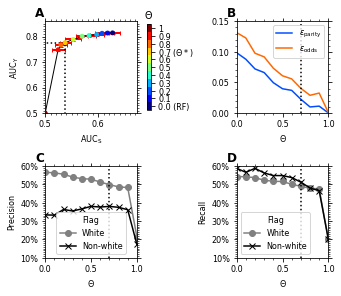

In [20]:
size = 12
with plt.rc_context({'font.size': 8, 'legend.fontsize': 8, 'legend.title_fontsize': 8}):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(4.6,4), constrained_layout=True)
    
    cmap = plt.cm.jet
    cmaplist = [cmap(i) for i in range(cmap.N)]
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)
    bounds = [-.05, .05, .15, .25, .35, .45, .55, .65, .75, .85, .95, 1.05]
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
    
    ax1.errorbar(data=total_performance, x='auc_s', y='auc_y', xerr='auc_s_std', yerr='auc_y_std', ecolor='red', elinewidth=2, capsize=2, color='black', lw=1)
    sc = ax1.scatter(data=total_performance, x='auc_s', y='auc_y', c=total_performance.index, s=15, cmap=cmap, norm=norm, zorder=10)
    clb = plt.colorbar(sc, ax=ax1, fraction=.046)
    clb.ax.set_title(r'$\Theta$')
    clb.set_ticks(ticks=np.linspace(0, 1, 11), labels=['0.0 (RF)', .1, .2, .3, .4, .5, .6, r'0.7 ($\Theta*$)', .8, .9, 1])
    ax1.vlines(total_performance.at[ortho_star, 'auc_s'], 0, total_performance.at[ortho_star, 'auc_y'], ls=':', color='black')
    ax1.hlines(total_performance.at[ortho_star, 'auc_y'], 0, total_performance.at[ortho_star, 'auc_s'], ls=':', color='black')
    ax1.set_xlim(.5)
    ax1.set_ylim(.5)
    ax1.set_xlabel(r'$\mathrm{AUC}_\mathrm{S}$')
    ax1.set_ylabel(r'$\mathrm{AUC}_\mathrm{Y}$')
    ax1.xaxis.set_ticks_position('both')
    ax1.yaxis.set_ticks_position('both')
    ax1.xaxis.set_major_locator(MultipleLocator(.1))
    ax1.yaxis.set_major_locator(MultipleLocator(.1))
    ax1.xaxis.set_minor_locator(MultipleLocator(.01))
    ax1.yaxis.set_minor_locator(MultipleLocator(.01))
    ax1.set_box_aspect(1)
    ax1.text(-.11, 1.05, 'A', transform=ax1.transAxes, size=size, weight='bold')
    ax1.set_anchor('C')

    ax2.plot('orthogonality', 'demographic parity', data=fairness_measures, label=r'$\epsilon_\mathrm{parity}$', color=cmap(.2))
    ax2.plot('orthogonality', 'equalised odds', data=fairness_measures, label=r'$\epsilon_\mathrm{odds}$', color=cmap(.8))
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, .15)
    ax2.set_xlabel(r'$\Theta$')
    ax2.xaxis.set_ticks_position('both')
    ax2.yaxis.set_ticks_position('both')
    ax2.xaxis.set_major_locator(MultipleLocator(.5))
    ax2.yaxis.set_major_locator(MultipleLocator(.05))
    ax2.xaxis.set_minor_locator(MultipleLocator(.1))
    ax2.yaxis.set_minor_locator(MultipleLocator(.01))
    ax2.legend(loc='upper right')
    ax2.set_box_aspect(1)
    ax2.text(-.11, 1.05, 'B', transform=ax2.transAxes, size=size, weight='bold')
    ax2.axvline(.7, 0, 1, ls=':', color='black')
    ax2.set_anchor('C')

    ax3.plot('orthogonality', 'precision (white)', data=fairness_measures, marker='o', color='grey', label='White')
    ax3.plot('orthogonality', 'precision (non-white)', data=fairness_measures, marker='x', color='black', label='Non-white')
    ax3.set_xlim(0, 1)
    ax3.set_ylim(.1, .6)
    ax3.set_xlabel(r'$\Theta$')
    ax3.set_ylabel('Precision')
    ax3.xaxis.set_ticks_position('both')
    ax3.yaxis.set_ticks_position('both')
    ax3.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.))
    ax3.xaxis.set_major_locator(MultipleLocator(.5))
    ax3.yaxis.set_major_locator(MultipleLocator(.1))
    ax3.xaxis.set_minor_locator(MultipleLocator(.1))
    ax3.yaxis.set_minor_locator(MultipleLocator(.01))
    ax3.legend(title='Flag', loc='lower center')
    ax3.set_box_aspect(1)
    ax3.text(-.11, 1.05, 'C', transform=ax3.transAxes, size=size, weight='bold')
    ax3.axvline(.7, 0, 1, ls=':', color='black')

    ax4.plot('orthogonality', 'recall (white)', data=fairness_measures, marker='o', color='grey', label='White')
    ax4.plot('orthogonality', 'recall (non-white)', data=fairness_measures, marker='x', color='black', label='Non-white')
    ax4.set_xlim(0, 1)
    ax4.set_ylim(.1, .6)
    ax4.set_xlabel(r'$\Theta$')
    ax4.set_ylabel('Recall')
    ax4.xaxis.set_ticks_position('both')
    ax4.yaxis.set_ticks_position('both')
    ax4.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.))
    ax4.xaxis.set_major_locator(MultipleLocator(.5))
    ax4.yaxis.set_major_locator(MultipleLocator(.1))
    ax4.xaxis.set_minor_locator(MultipleLocator(.1))
    ax4.yaxis.set_minor_locator(MultipleLocator(.01))
    ax4.legend(title='Flag', loc='lower left')
    ax4.set_box_aspect(1)
    ax4.text(-.11, 1.05, 'D', transform=ax4.transAxes, size=size, weight='bold')
    ax4.axvline(.7, 0, 1, ls=':', color='black')
    fig.savefig('fig/fairness.pdf', bbox_inches='tight')

In [21]:
total_performance

,auc_y,auc_y_std,auc_s,auc_s_std
orthogonality,,,,
0.0,0.814402,0.003850,0.626898,0.013815
0.1,0.813765,0.003883,0.617525,0.012643
0.2,0.812861,0.005782,0.607162,0.013119
0.3,0.807987,0.003998,0.597155,0.012933
0.4,0.803892,0.006532,0.582603,0.013076
0.5,0.801250,0.004161,0.569496,0.010762
0.6,0.788647,0.007466,0.552828,0.014602
0.7,0.776182,0.008163,0.537640,0.010588
0.8,0.766792,0.008514,0.529537,0.011115


# Fairness measures for different $\Theta$ and thresholds

In [22]:
best_params.loc[lambda x: (x.orthogonality == 0) & (x.outer_fold == 0)].iloc[0]

orthogonality    0.0
outer_fold       0.0
max_depth        6.0
n_bins           2.0
Name: 5, dtype: float64

In [23]:
values = [.1, .3, .5, .7, .9]
iterator = [
    (orthogonality, threshold_quantile, fold) 
    for orthogonality in values 
    for threshold_quantile in values 
    for fold in range(5)
]

y_scores_all = dict()
y_test_all = dict()
s_test_all = dict()
thresholds = dict()
y_pred_all = dict()
fairness_measures = list()

for orthogonality in values:
    for threshold_quantile in values:      
        y_scores_all[(orthogonality, threshold_quantile)] = list()
        y_test_all[(orthogonality, threshold_quantile)] = list()
        s_test_all[(orthogonality, threshold_quantile)] = list()

for ortho, threshold_quantile, fold in tqdm(iterator):    
    best_params_ = best_params.loc[lambda x: (x.orthogonality.round(1) == ortho) & (x.outer_fold == fold)].iloc[0]
    max_depth = int(best_params_['max_depth'])
    n_bins = int(best_params_['n_bins'])
    filepath = f'models/outer_folds/{max_depth}-{ortho:.2f}-{n_bins}-{fold}.npy'
    y_score = np.load(filepath)
    
    _, (_, test_idx) = outer_folds[fold]
    assert len(y_score) == len(test_idx)
    
    y_test = y[test_idx]
    s_test = s[test_idx]
    assert len(y_score) == len(y_test)
    assert len(s_test) == len(y_score)
    
    # FLIPPING!!!
    y_scores_all[(ortho, threshold_quantile)].extend(1-y_score)
    y_test_all[(ortho, threshold_quantile)].extend(~y_test)
    
    s_test_all[(ortho, threshold_quantile)].extend(s_test)

for orthogonality in values:
    for threshold_quantile in values: 
        i = (orthogonality, threshold_quantile)
        y_score = np.array(y_scores_all[i])
        y_test = np.array(y_test_all[i])
        s_test = np.array(s_test_all[i])
        threshold = np.quantile(y_scores_all[i], threshold_quantile)
        
        y_pred = y_score > threshold
        ppr_w = y_pred[~s_test].mean()
        ppr_b = y_pred[s_test].mean()
        
        fpr_w = (y_score > threshold)[~y_test & ~s_test].mean()
        fpr_b = (y_score > threshold)[~y_test & s_test].mean()
        tpr_w = (y_score > threshold)[y_test & ~s_test].mean()
        tpr_b = (y_score > threshold)[y_test & s_test].mean()
        
        fairness_measures.append(
            {
                'orthogonality': orthogonality,
                'threshold quantile': threshold_quantile,
                'demographic parity': abs(ppr_w - ppr_b),
                'equalized odds': max(abs(fpr_w - fpr_b), abs(tpr_w - tpr_b))
            }
        )
fairness_measures = pd.DataFrame(fairness_measures)

  0%|          | 0/125 [00:00<?, ?it/s]

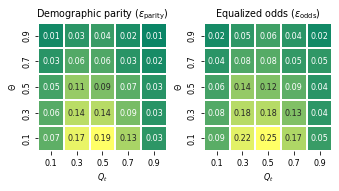

In [24]:
disparate_impact = fairness_measures.pivot('orthogonality', 'threshold quantile', 'demographic parity').sort_index(ascending=False)
equalized_odds = fairness_measures.pivot('orthogonality', 'threshold quantile', 'equalized odds').sort_index(ascending=False)

with plt.rc_context({'font.size': 8, 'legend.fontsize': 8, 'legend.title_fontsize': 8}):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4.6, 4.6*(2/3)), constrained_layout=True)
    sns.heatmap(disparate_impact, vmin=0, square=True, annot=True, annot_kws={'size': 8}, fmt='.2f', linewidths=.1, cmap='summer', cbar=False, ax=ax1)
    ax1.set_title(r"Demographic parity ($\epsilon_\mathrm{parity}$)")
    ax1.set_xlabel(r'$Q_t$')
    ax1.set_ylabel(r'$\Theta$')

    sns.heatmap(equalized_odds, vmin=0, square=True, annot=True, fmt='.2f', linewidths=.1, cmap='summer', cbar = False, ax=ax2)
    ax2.set_title(r"Equalized odds ($\epsilon_\mathrm{odds}$)")
    ax2.set_xlabel(r'$Q_t$')
    ax2.set_ylabel(r'$\Theta$')
    fig.savefig('fig/fairness-measures.pdf',bbox_inches='tight')